In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import matplotlib
import os
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import numpy as np
import xarray as xr
import scipy   
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.model_selection import KFold
from scipy import io
from scipy import stats
import pickle
import tensorflow
import numpy as np
import pyaldata
from pyaldata import *
import keras
from tensorflow.keras.models import Sequential
import keras.models
import mgplvm as mgp # to clone 
from scipy.io import loadmat

torch.cuda.is_available()

loading


True

In [2]:
# keep on the gpu it runs faster 
np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU

In [3]:
device='cpu'

In [4]:
data_dir = "/home/md5218/THESIS/intro_pyaldata/bGPFA/"
fname_data = os.path.join(data_dir, "Mihili_RT_FF_2014-02-14_2.mat")

In [5]:
data=mat2dataframe(fname_data, shift_idx_fields=True)
# data = scipy.io.loadmat(fname, simplify_cells=True)
binsize=20

In [6]:
data.columns

Index(['monkey', 'date', 'task', 'target_center', 'trial_id', 'result',
       'bin_size', 'perturbation', 'epoch', 'perturbation_info',
       'idx_trial_start', 'idx_go_cue', 'idx_trial_end', 'pos', 'vel', 'acc',
       'force', 'M1_spikes', 'M1_unit_guide', 'PMd_spikes', 'PMd_unit_guide'],
      dtype='object')

In [7]:
#for this data frame each trial =  4 (x,y) target reaching task 
""" target of each trial stored in target_center - must correct them """
data.target_center[0].shape #4 targets in space, 2(x,y)
for trial in range (0, 741): 
    targets=data.target_center[trial]
    targets=targets.flatten()[[0, 2, 4, 6, 1, 3, 5, 7]].reshape(-1, 2)
    data.target_center[trial]=targets

/tmp/ipykernel_1137892/2969094151.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.target_center[trial]=targets


In [8]:
""" center signal """
data=center_signal(data, 'pos')

In [9]:
"""1. remove low firing neurons - M1 has higher firing rates """
print("original M1: ", data.M1_spikes[0].shape) #22 neurons 
print("original PMd: ", data.PMd_spikes[0].shape) #94 neurons 
data_1 = remove_low_firing_neurons(data, "M1_spikes",  5)
data_1 = remove_low_firing_neurons(data, "PMd_spikes", 2)
print("post removal M1:  ", data_1.M1_spikes[0].shape) #22 neurons - all contributing 
print("post removal PMd:  ", data_1.PMd_spikes[0].shape) #55 neurons - reduced 

original M1:  (2576, 22)
original PMd:  (2576, 94)
post removal M1:   (2576, 22)
post removal PMd:   (2576, 55)


/home/md5218/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/md5218/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [10]:
"""2. merge neurons from motor and premotor cortices """
data_2 = merge_signals(data_1, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {data_1.M1_spikes[0].shape[1]} + {data_1.PMd_spikes[0].shape[1]} = {data_2.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 22 + 55 = 77 neurons


In [11]:
"""3. transform signals - take sqrt transform so that even neurons firing less have a considerable weight """
#data_3 = transform_signal(data_2, "both_spikes",  'sqrt')

'3. transform signals - take sqrt transform so that even neurons firing less have a considerable weight '

In [12]:
"""4. add firing rates """
# data_4 = add_firing_rates(data_3, 'smooth', std=0.1)
# data_4.both_rates[0].shape #741 trials

# HERE NEURAL ACTIVITY IS USED NOT FIRING RATES 
# data=data_3

'4. add firing rates '

In [13]:
data=data_2
data.columns
data.perturbation.unique()
data_2.both_spikes[0].shape #(2576, 77)

(2576, 77)

In [14]:
# try downsampling data ... to use more a longer duration on the gpu 
data=combine_time_bins(data, 2)
data.both_spikes[0].shape #(1288, 77)

(1288, 77)

In [15]:
type(data) #pandas.core.frame.DataFrame
type(data.both_spikes) #pandas.core.series.Series
type(np.array(data.both_spikes)) #numpy.ndarray

numpy.ndarray

In [16]:
def concat_trials(trial_data, signal, trial_indices=None):
    """
    Concatenate signal from different trials in time

    Parameters
    ----------
    trial_data : pd.DataFrame
        data in trial_data format
    signal : str
        name of the field to concatenate
    trial_indices : array-like of ints
        indices of the trials we want to get the signal from

    Returns
    -------
    np.array of the signal in the selected trials
    stacked on top of each other
    """
    if trial_indices is None:
        return np.concatenate(trial_data[signal].values, axis=0)
    else:
        return np.concatenate(trial_data.loc[trial_indices, signal].values, axis=0)

In [17]:
# Since here not all trials have same length, np.array having dimensions 740 x 77 x [] not possible 
# either zero padding for all trials - but too much difference in length (min 250, max 2500 timebins)
# or concatenate all trials and treat like a single long one 


# FOR STORAGE reasons use the first 15000 time bins, but with a resolution of 20 ms it corresponds to 300s = 5mins

Y=concat_trials(data, 'both_spikes')
Y=np.array(np.transpose(Y[1:100001, :])) #(77, 328429), or only considering 30000 samples to see if it works 
num_neurons=Y.shape[0]
T_all_trials=Y.shape[1]
Y=np.reshape(Y, (1, num_neurons, T_all_trials))
Y.shape #(1, 77, 328429) #(1, 77, 164034) downsampling

(1, 77, 100000)

In [18]:
Y[0, 1, :]  # here zeros & decimals ... make all either 0 or 1 --- as a consequence of sqrt and smoothing 
# adding firing rates also smooths signals!!! do not, bGPFA does it 

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
locs=concat_trials(data, 'pos')
locs=np.array(locs[1:100001, :]) #(2, 328429), only considering 30000 thousand positions (30000, 2)
T_all_trials=locs.shape[1]
locs.shape #(328429, 2)

(100000, 2)

In [20]:
vel=concat_trials(data, 'vel')
vel=np.array(vel[1:100001, :]) #(2, 328429), only considering 30000 thousand positions (30000, 2)
T_all_trials=vel.shape[1]
vel.shape #(328429, 2)

(100000, 2)

In [21]:
data.target_center[0].shape # 4 targets per trial, 2 dimensions x y
targets=concat_trials(data, 'target_center')
targets=np.array(targets) #(2, 4x741 = 2964)
multiple_trials=targets.shape[1] # 4 x num_trials = 2964
#targets=np.reshape(targets, (1, 2, multiple_trials))
targets.shape #(1, 2, 2964)

(2964, 2)

In [22]:
### set some parameters for fitting ###
ell0 = 200/binsize # initial timescale (in bins) for each dimension. This could be the ~timescale of the behavior of interest 
                   #(otherwise a few hundred ms is a reasonable default)
# NOTE GPFA already fits multiple timescales to dimensions of X - i.e. to latent variables progressing in time 

rho = 2 # sets the intial scale of each latent (s_d in Jensen & Kao). 
        # rho=1 is a natural choice with Gaussian noise; less obvious w/ non-Gaussian noise but rho=1-5 works well empirically
    
max_steps = 1001 # number of training iterations 1001

# MONTE CARLO SAMPLING: https://machinelearningmastery.com/monte-carlo-sampling-for-probability/ 
# MC iterations changed from 5 to 10  
n_mc = 4 # number of monte carlo samples per iteration 

print_every = 100 # how often we print training progress

# changing number of dimensions from 10 to 30 - uninformative dimensions can be discarded later 
d_fit = 40 # lets fit up to 10 latent dimensions (in theory this could be up to the number of neurons; 
           # should be thought of as an upper bound to how high-dimensional the activity is)
# NOTE in PCA 27 dimensions used - with threshold of explained variance 

In [23]:
#only considering high firing neurons == removing low firing neurons 

#Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 8, :] #subsample highly active neurons so things will run a bit quicker
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]
data = torch.tensor(Y).to(device) # put the data on our GPU/CPU --- making data into a tensor 
ts = np.arange(Y.shape[-1]) #much easier to work in units of time bins here --- creating a vector for units of time bins
fit_ts = torch.tensor(ts)[None, None, :].to(device) # put our time points on GPU/CPU --- making time vector into a tensor 


In [24]:
# where jensen et al find points where target changes here not done 
# because in their dataset there's a target variable with the target locs at every point in time 
# while here only the 4 target center per trial are found 
# so moment in time when target locs changes not found  

In [25]:
fit_ts.shape #[1, 1, 30000]
data.shape #[1, 2, 30000]
Y.shape #[1, 2, 30000] ----- downsampled to 2 neurons? 
#type(Y) #numpy.ndarray
Y.shape #[1, 77, 30000] ----- without subsamplinh highly active neurons, but after removing low firing neurons 

(1, 77, 100000)

In [30]:
### construct the actual model ###
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]
lik = mgp.likelihoods.NegativeBinomial(n, Y=Y) # we use a negative binomial noise model in this example 
                                               # (recommended for ephys data)
#lik = mgp.likelihoods.Poisson(n)
manif = mgp.manifolds.Euclid(T, d_fit) # latent variables live in Euclidean space for bGPFA (alternatives in Jensen et al. 2020)
var_dist = mgp.rdist.GP_circ(manif, T, ntrials, fit_ts, _scale=1, ell = ell0) # circulant variational GP posterior 
                                                                              # (Jensen & Kao et al. 2021)
lprior = mgp.lpriors.Null(manif) # here the prior is defined implicitly in our variational distribution, 
                                 # but if we wanted to fit e.g. Factor analysis this would be a Gaussian prior
mod = mgp.models.Lvgplvm(n, T, d_fit, ntrials, var_dist, lprior, lik, Y = Y, learn_scale = False, ard = True, 
                         rel_scale = rho).to(device)  #create bGPFA model with ARD

In [33]:
### training will proceed for 1000 iterations (this takes ~2 minutes) ###
# up to training not needed targets 
t0 = time.time()
def cb(mod, i, loss):
    """here we construct an (optional) function that helps us keep track of the training"""
    if i % print_every == 0:
        sd = np.log(mod.obs.dim_scale.detach().cpu().numpy().flatten())
        print('iter:', i, 'time:', str(round(time.time()-t0))+'s', 'log scales:', np.round(sd[np.argsort(-sd)], 1))

# helper function to specify training parameters
train_ps = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, lrate = 7.5e-2, callback = cb, print_every = np.nan)
print('fitting', n, 'neurons and', T, 'time bins for', max_steps, 'iterations')
mod_train = mgp.crossval.train_model(mod, data, train_ps)

fitting 77 neurons and 100000 time bins for 1001 iterations


/home/md5218/mambaforge/envs/neuro_data/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853668/work/aten/src/ATen/native/Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_1137892/2464679026.py:7: RuntimeWarning: divide by zero encountered in log
  sd = np.log(mod.obs.dim_scale.detach().cpu().numpy().flatten())


iter: 0 time: 40s log scales: [-2.  -2.1 -2.5 -2.6 -3.  -3.1 -3.2 -3.2 -3.3 -3.4 -3.4 -3.6 -3.6 -3.7
 -3.7 -3.7 -3.8 -3.9 -4.  -4.  -4.2 -4.2 -4.3 -4.3 -4.3 -4.4 -4.4 -4.5
 -4.6 -4.7 -4.7 -4.8 -4.8 -5.3 -5.4 -5.6 -inf -inf -inf -inf]
iter: 100 time: 4199s log scales: [-2.1 -2.1 -2.5 -2.5 -2.6 -2.8 -2.8 -2.9 -2.9 -2.9 -3.  -3.  -3.1 -3.1
 -3.2 -3.2 -3.3 -3.3 -3.4 -3.4 -3.4 -3.5 -3.8 -4.  -4.  -4.2 -4.2 -4.3
 -4.4 -4.7 -4.7 -4.7 -4.8 -5.2 -5.5 -5.6 -inf -inf -inf -inf]
iter: 200 time: 8313s log scales: [-1.8 -2.2 -2.4 -2.5 -2.5 -2.6 -2.6 -2.6 -2.6 -2.7 -2.7 -2.7 -2.7 -2.7
 -2.7 -2.7 -2.8 -2.8 -2.8 -2.8 -2.9 -2.9 -2.9 -3.  -3.  -3.4 -3.5 -4.4
 -4.4 -5.1 -5.1 -5.1 -5.2 -5.7 -5.9 -6.1 -inf -inf -inf -inf]
iter: 300 time: 12427s log scales: [-1.8 -2.2 -2.2 -2.2 -2.3 -2.3 -2.3 -2.3 -2.3 -2.4 -2.4 -2.4 -2.4 -2.5
 -2.5 -2.5 -2.5 -2.5 -2.5 -2.6 -2.6 -2.6 -2.6 -2.6 -2.7 -2.8 -2.8 -4.8
 -4.8 -5.5 -5.6 -5.7 -5.7 -6.2 -6.4 -6.5 -inf -inf -inf -inf]
iter: 400 time: 16470s log scales: [-1.7 -1.9 -2.  

0.05999999999999872

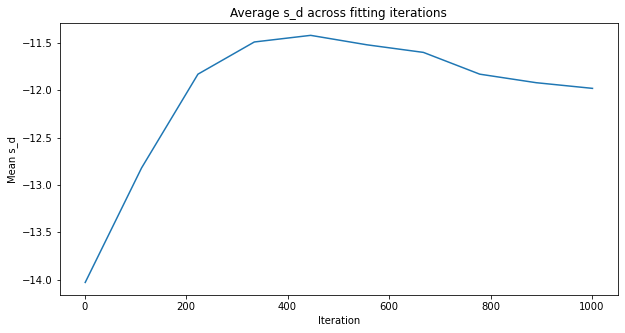

In [39]:
iter=np.linspace(1, 1001, 10)
s_d_values=[[-2  -2.1 -2.5 -2.6 -3.  -3.1 -3.2 -3.2 -3.3 -3.4 -3.4 -3.6 -3.6 -3.7
 -3.7 -3.7 -3.8 -3.9 -4.  -4.  -4.2 -4.2 -4.3 -4.3 -4.3 -4.4 -4.4 -4.5
 -4.6 -4.7 -4.7 -4.8 -4.8 -5.3 -5.4 -5.6],[ -2.1 -2.2 -2.3 -2.4 -2.6 -2.8 -2.8 -2.8 -2.8 -2.9 -3.  -3.1 -3.1 -3.1
 -3.2 -3.2 -3.2 -3.2 -3.4 -3.5 -3.6 -3.6 -3.7 -3.8 -3.9 -3.9 -4.  -4.2
 -4.4 -4.6 -4.7 -4.8 -4.8 -5.3 -5.5 -5.7],[ -1.9 -2.2 -2.2 -2.3 -2.5 -2.5 -2.6 -2.6 -2.7 -2.7 -2.7 -2.7 -2.7 -2.7
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.9 -2.9 -2.9 -2.9 -2.9 -3.1 -3.3
 -4.8 -5.  -5.  -5.2 -5.2 -5.7 -5.9 -6.],[ -1.8 -2.2 -2.2 -2.2 -2.2 -2.3 -2.3 -2.4 -2.4 -2.4 -2.4 -2.4 -2.4 -2.4
 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.6 -2.6 -2.6 -2.6 -2.6 -2.7 -2.8 -2.9
 -5.3 -5.5 -5.5 -5.6 -5.7 -6.1 -6.3 -6.5],[ -1.6 -2.  -2.  -2.1 -2.1 -2.1 -2.2 -2.2 -2.2 -2.2 -2.3 -2.3 -2.3 -2.3
 -2.3 -2.4 -2.4 -2.4 -2.4 -2.4 -2.4 -2.5 -2.5 -2.5 -2.6 -2.6 -2.7 -2.8
 -5.7 -5.9 -5.9 -5.9 -6.1 -6.4 -6.7 -6.8],[ -1.4 -1.9 -1.9 -1.9 -2.  -2.  -2.1 -2.1 -2.2 -2.2 -2.2 -2.2 -2.2 -2.2
 -2.3 -2.3 -2.4 -2.4 -2.4 -2.4 -2.4 -2.5 -2.5 -2.5 -2.5 -2.7 -2.8 -2.8
 -6.  -6.2 -6.2 -6.2 -6.4 -6.7 -7.  -7.1],[ -1.3 -1.8 -1.8 -1.8 -1.9 -1.9 -2.  -2.1 -2.1 -2.1 -2.1 -2.2 -2.2 -2.2
 -2.3 -2.3 -2.4 -2.4 -2.4 -2.4 -2.4 -2.5 -2.5 -2.5 -2.5 -2.7 -2.8 -2.9
 -6.3 -6.4 -6.4 -6.4 -6.6 -6.9 -7.2 -7.3],[ -1.2 -1.7 -1.7 -1.8 -1.8 -1.8 -1.9 -2.  -2.1 -2.1 -2.1 -2.2 -2.2 -2.2
 -2.3 -2.3 -2.4 -2.4 -2.4 -2.5 -2.5 -2.5 -2.5 -2.6 -2.6 -2.7 -2.8 -2.9
 -6.6 -6.7 -6.8 -6.8 -6.9 -7.2 -7.5 -7.6],[ -1.1 -1.7 -1.7 -1.8 -1.8 -1.8 -1.8 -2.  -2.  -2.1 -2.1 -2.2 -2.2 -2.2
 -2.3 -2.3 -2.4 -2.4 -2.4 -2.5 -2.5 -2.5 -2.5 -2.6 -2.6 -2.7 -2.8 -2.9
 -6.8 -6.9 -6.9 -6.9 -7.1 -7.4 -7.6 -7.7],[ -1.1 -1.7 -1.7 -1.7 -1.8 -1.8 -1.8 -2.  -2.  -2.1 -2.1 -2.2 -2.2 -2.2
 -2.3 -2.3 -2.4 -2.4 -2.4 -2.4 -2.5 -2.5 -2.5 -2.6 -2.6 -2.7 -2.8 -2.8
 -6.9 -7.  -7.  -7.1 -7.2 -7.5 -7.7 -7.8]]
len(s_d_values)
fig, ax = plt.subplots(figsize = (10, 5), nrows=1)
average_sd=np.mean(s_d_values, 1)/10
plt.plot(iter, average_sd)
plt.title("Average s_d across fitting iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean s_d") 
average_sd[8]-average_sd[9] # 0.06 = 0.5 % of -12 mean sd --- 

In [40]:
#uncomment this section when loading the saved model rather than rerunning it 
fname_model = os.path.join(data_dir, "model")
model=torch.load(fname_model)
X = model.lat_dist.lat_mu.detach().cpu().numpy()[0, ...]

plotting informative and discarded dimensions


/tmp/ipykernel_1137892/74666129.py:4: RuntimeWarning: divide by zero encountered in log
  dim_scales = np.log(dim_scales) #take the log of the prior scales


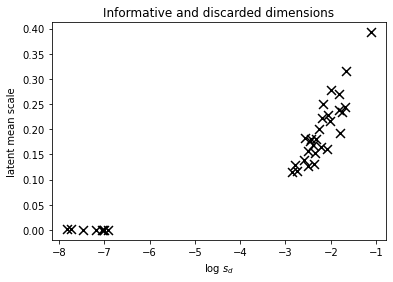

In [41]:
### we start by plotting 'informative' and 'discarded' dimensions ###
print('plotting informative and discarded dimensions')
dim_scales = model.obs.dim_scale.detach().cpu().numpy().flatten() #prior scales (s_d)
dim_scales = np.log(dim_scales) #take the log of the prior scales
nus = np.sqrt(np.mean(model.lat_dist.nu.detach().cpu().numpy()**2, axis = (0, -1))) #magnitude of the variational mean
plt.figure()
plt.scatter(dim_scales, nus, c = 'k', marker = 'x', s = 80) #top right corner are informative, lower left discarded
plt.xlabel(r'$\log \, s_d$')
plt.ylabel('latent mean scale', labelpad = 5)
plt.title('Informative and discarded dimensions')
plt.savefig('informative_dims.jpeg')
plt.show()
# with 10 dimensions, 5 are discarded 
# with 30 dimensions, 15 are discarded 
# with 30 dimensions, 100,000 samples and only 4 are discarded --- dimensionality 26, in pca 27 
# with 40 dimesnions, 100,000 samples and 12 are discarded --- dimensionality 28, in pca 27

In [42]:
informative=[]
for i in range (0, len(dim_scales)): 
    if dim_scales[i]>(-5): 
        informative.append(dim_scales[i])
len(informative) #28 

28

plotting latent trajectories


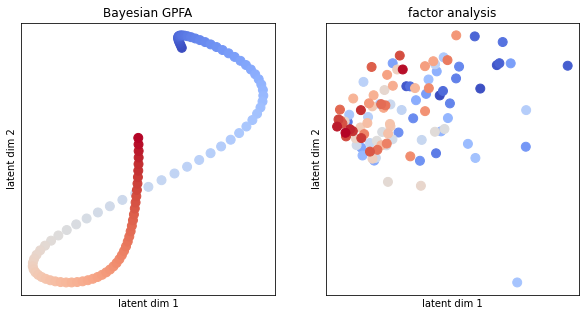

learned timescales (ms): [574 126 299 709 111 291 124 187 200 197 254 843  94 178 118 663 400 226
 304 660 391 160 509 883 203 224 209 722 112 200 200 201 206 203 202 202
 200 200 200 200]


In [43]:
### plot the inferred latent trajectories
print('plotting latent trajectories')
X = mod.lat_dist.lat_mu.detach().cpu().numpy()[0, ...] # extract inferred latents ('mu' has shape (ntrials x T x d_fit))
X = X[..., np.argsort(-dim_scales)] # only consider the two most informative dimensions (c.f. Jensen & Kao)
tplot = np.arange(300, 400) # let's only plot a shorter period (here 2.s) so it doesn't get too cluttered
# fit FA for comparison
fa = FactorAnalysis(2)
Xfa = fa.fit_transform(np.sqrt(Y[0, ...].T)) # sqrt the counts for variance stabilization (c.f. Yu et al. 2009)

i1, i2 = 2, 3 # which dimensions to plot
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].scatter(X[tplot, i1], X[tplot, i2], c = tplot, cmap = 'coolwarm', s = 80) # plot bGPFA latents
axs[1].scatter(Xfa[tplot, 0], Xfa[tplot, 1], c = tplot, cmap = 'coolwarm', s = 80) # plot FA latents
for ax in axs:
    ax.set_xlabel('latent dim 1')
    ax.set_ylabel('latent dim 2')
    ax.set_xticks([])
    ax.set_yticks([])
axs[0].set_title('Bayesian GPFA')
axs[1].set_title('factor analysis')
plt.show()
# let's also print the learned timescales (sorted by the prior scales s_d)
taus = mod.lat_dist.ell.detach().cpu().numpy().flatten()[np.argsort(-dim_scales)]*binsize
print('learned timescales (ms):', np.round(taus).astype(int))

running decoding analysis
plotting decoding


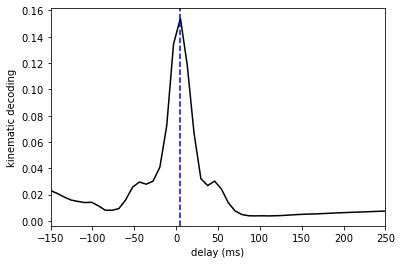

In [44]:
#ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior ---- smoothing step -- ... 
vels = cs(ts, 1) # velocity (first derivative)
### finally let's do a simple decoding analysis ###

print('running decoding analysis')
Ypreds = [] # decode from the inferred firing rates (this is a non-linear decoder from latents)
query = mod.lat_dist.lat_mu.detach().transpose(-1, -2).to(device)  # (ntrial, d_fit, T)
for i in range(10): # loop over mc samples to avoid memory issues
    Ypred = mod.svgp.sample(query, n_mc=100, noise=False)
    Ypred = Ypred.detach().mean(0).cpu().numpy()  # (ntrial x n x T)
    Ypreds.append(Ypred)
Ypred = np.mean(np.array(Ypreds), axis = (0,1)).T # T x n ----- all trials concatenated ????? 

delays = np.linspace(-150, 250, 50) # consider different behavioral delays
performance = np.zeros((len(delays), 2)) # model performance
for idelay, delay in enumerate(delays):
    vels = cs(ts+delay, 1) # velocity at time+delay
    for itest, Ytest in enumerate([Ypred]): # bGPFA
        regs = [Ridge(alpha=1e-3).fit(Ytest[::2, :], vels[::2, i]) for i in range(2)] # fit x and y vel on half the data
        scores = [regs[i].score(Ytest[1::2, :], vels[1::2, i]) for i in range(2)] # score x and y vel on the other half
        performance[idelay, itest] = np.mean(scores) # save performance
print('plotting decoding')
plt.figure()
plt.plot(delays, performance[:, 0], 'k-')
plt.axvline(delays[np.argmax(performance[:, 0])], color = 'b', ls = '--')
plt.xlim(delays[0], delays[-1])
plt.xlabel('delay (ms)') # delay between neural activity and behavior 
plt.ylabel('kinematic decoding')  # scores 
plt.show()

# performance vs delay only when the input field is P(F|X) 

# CHECK THIS 

In [45]:
#uncomment this section when loading the saved model rather than rerunning it 

Ypreds = [] # decode from the inferred firing rates (this is a non-linear decoder from latents)
query = model.lat_dist.lat_mu.detach().transpose(-1, -2).to(device)  # (ntrial, d_fit, T)
for i in range(10): # loop over mc samples to avoid memory issues
    Ypred = model.svgp.sample(query, n_mc=100, noise=False)
    Ypred = Ypred.detach().mean(0).cpu().numpy()  # (ntrial x n x T)
    Ypreds.append(Ypred)
Ypred = np.mean(np.array(Ypreds), axis = (0,1)).T # T x n ----- all trials concatenated ????? 


running decoding analysis
plotting decoding


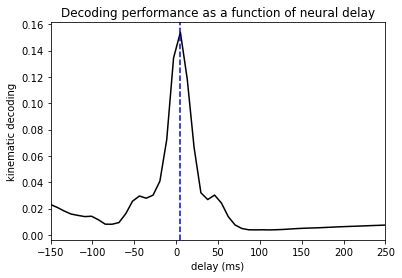

In [46]:
#ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
vels = cs(ts, 1) # velocity (first derivative)
### finally let's do a simple decoding analysis ###

print('running decoding analysis')
Ypreds = [] # decode from the inferred firing rates (this is a non-linear decoder from latents)
query = mod.lat_dist.lat_mu.detach().transpose(-1, -2).to(device)  # (ntrial, d_fit, T)
for i in range(10): # loop over mc samples to avoid memory issues
    Ypred = mod.svgp.sample(query, n_mc=100, noise=False)
    Ypred = Ypred.detach().mean(0).cpu().numpy()  # (ntrial x n x T)
    Ypreds.append(Ypred)
Ypred = np.mean(np.array(Ypreds), axis = (0,1)).T # T x n ----- all trials concatenated 

delays = np.linspace(-150, 250, 50) # consider different behavioral delays
performance = np.zeros((len(delays), 2)) # model performance
for idelay, delay in enumerate(delays):
    vels = cs(ts+delay, 1) # velocity at time+delay
    for itest, Ytest in enumerate([Ypred]): # bGPFA
        regs = [LinearRegression().fit(Ytest[::2, :], vels[::2, i]) for i in range(2)] # fit x and y vel on half the data
        scores = [regs[i].score(Ytest[1::2, :], vels[1::2, i]) for i in range(2)] # score x and y vel on the other half
        performance[idelay, itest] = np.mean(scores) # save performance
print('plotting decoding')
plt.figure()
plt.plot(delays, performance[:, 0], 'k-')
plt.axvline(delays[np.argmax(performance[:, 0])], color = 'b', ls = '--')
plt.xlim(delays[0], delays[-1])
plt.xlabel('delay (ms)') # delay between neural activity and behavior 
plt.ylabel('kinematic decoding')  # scores 
plt.title('Decoding performance as a function of neural delay')
plt.savefig('no_delay_bGPFA.jpeg')
plt.show()

LINEAR & RIDGE REGRESSION ---- CROSS VALIDATION 

In [47]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split, validation_curve

In [48]:
data_dir = "/home/md5218/THESIS/intro_pyaldata/bGPFA/"
fname_model = os.path.join(data_dir, "model")

In [49]:
locs.shape
X.shape
#mod.save()
#torch.save(mod, fname_model) 
X = model.lat_dist.lat_mu.detach().cpu().numpy()[0, ...]

In [50]:
X.shape

(100000, 40)

In [51]:
cv_scores_X_vel_x = cross_val_score(LinearRegression(), X, vel[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_vel_x = cross_val_score(LinearRegression(), Ypred, vel[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_vel_y = cross_val_score(LinearRegression(), X, vel[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_vel_y = cross_val_score(LinearRegression(), Ypred, vel[:, 1], cv = KFold(10, shuffle=True))
cv_scores_X_posx = cross_val_score(LinearRegression(), X, locs[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_posx = cross_val_score(LinearRegression(), Ypred, locs[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_velx_r = cross_val_score(Ridge(alpha=1e-5), X, vel[:,0], cv = KFold(10, shuffle=True))
cv_scores_X_vely_r = cross_val_score(Ridge(alpha=1e-5), X, vel[:,1], cv = KFold(10, shuffle=True))
cv_scores_X_posx_r = cross_val_score(Ridge(alpha=1e-5), X, locs[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_velx_r = cross_val_score(Ridge(alpha=1e-5), Ypred, vel[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_vely_r = cross_val_score(Ridge(alpha=1e-5), Ypred, vel[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_posx_r = cross_val_score(Ridge(alpha=1e-5), Ypred, locs[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_posy = cross_val_score(LinearRegression(), X, locs[:, 1], cv = KFold(10, shuffle=True))
cv_scores_X_posy_r = cross_val_score(Ridge(alpha=1e-5), X, locs[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_posy = cross_val_score(LinearRegression(), Ypred, locs[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_posy_r = cross_val_score(Ridge(alpha=1e-5), Ypred, locs[:, 1], cv = KFold(10, shuffle=True))

In [52]:
d = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'X-velx, LR': cv_scores_X_vel_x ,
     'F-velx, LR': cv_scores_F_vel_x ,
     'X-vely, LR': cv_scores_X_vel_y ,
     'F-vely, LR': cv_scores_F_vel_y ,
     'X-posx, LR': cv_scores_X_posx ,
     'F-posx, LR': cv_scores_F_posx , 
     'X-velx, Ridge': cv_scores_X_velx_r,
     'F-velx, Ridge': cv_scores_F_velx_r,
     'X-vely, Ridge': cv_scores_X_vely_r,
     'F-vely, Ridge': cv_scores_F_vely_r,
     'X-posx, Ridge': cv_scores_X_posx_r ,
     'F-posx, Ridge': cv_scores_F_posx_r, 
     'X-posy, LR': cv_scores_X_posy ,
     'F-posy, LR': cv_scores_F_posy , 
     'X-posy, Ridge': cv_scores_X_posy_r ,
     'F-posy, Ridge': cv_scores_F_posy_r
    }
pd.set_option('display.max_columns', None)
cv_scores = pd.DataFrame(data=d)
cv_scores

,K,"X-velx, LR","F-velx, LR","X-vely, LR","F-vely, LR","X-posx, LR","F-posx, LR","X-velx, Ridge","F-velx, Ridge","X-vely, Ridge","F-vely, Ridge","X-posx, Ridge","F-posx, Ridge","X-posy, LR","F-posy, LR","X-posy, Ridge","F-posy, Ridge"
0,1,0.462337,0.514744,0.480234,0.543443,0.550358,0.491721,0.459588,0.519065,0.476863,0.556952,0.545470,0.505256,0.598177,0.581670,0.607210,0.565814
1,2,0.452727,0.516024,0.478110,0.548333,0.537620,0.486241,0.455369,0.518497,0.483157,0.547859,0.540131,0.498392,0.598010,0.571521,0.589927,0.574349
2,3,0.454762,0.507421,0.482397,0.564809,0.548759,0.489801,0.462431,0.523983,0.476989,0.545151,0.550545,0.497509,0.592074,0.573506,0.593673,0.570967
3,4,0.451035,0.516413,0.476531,0.555600,0.553886,0.494920,0.452484,0.533029,0.474619,0.547721,0.553739,0.493413,0.602094,0.568009,0.609553,0.574668
4,5,0.457651,0.525984,0.484561,0.548129,0.553850,0.492700,0.467688,0.506744,0.482778,0.561708,0.545080,0.489289,0.606653,0.571135,0.601048,0.574881
5,6,0.451592,0.521721,0.478326,0.560083,0.546752,0.495842,0.447754,0.514573,0.479709,0.554692,0.541586,0.505158,0.609535,0.580309,0.585786,0.577435
6,7,0.458394,0.507429,0.481327,0.551426,0.543792,0.503845,0.459033,0.510829,0.477095,0.550667,0.540695,0.499791,0.592446,0.577440,0.610849,0.569207
7,8,0.479927,0.518676,0.482677,0.560503,0.538147,0.504548,0.464348,0.500014,0.485900,0.550074,0.542756,0.496746,0.590362,0.579393,0.604184,0.573032
8,9,0.463537,0.504227,0.478817,0.541233,0.552566,0.514293,0.467643,0.504608,0.489955,0.550728,0.552935,0.490775,0.599043,0.559859,0.581104,0.579971
9,10,0.462475,0.520701,0.486284,0.551913,0.532336,0.495812,0.457846,0.521034,0.482445,0.559978,0.545293,0.494373,0.596001,0.573871,0.599598,0.576819


Text(0.5, 1.0, '10-fold CV, scores - Linear and Ridge Regression, Predicting Horizontal Position')

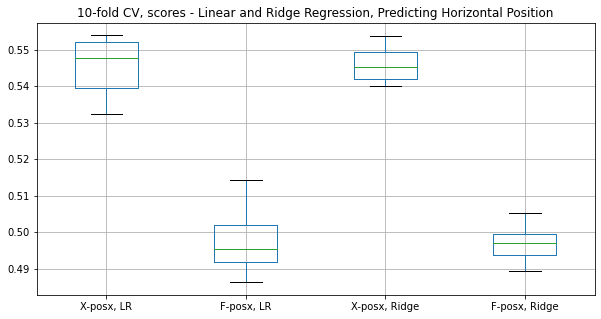

In [53]:
fig, ax = plt.subplots(figsize = (10, 5))
boxplot_pos = cv_scores.boxplot(column=['X-posx, LR', 'F-posx, LR', 'X-posx, Ridge', 'F-posx, Ridge'])  
boxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Horizontal Position')

Text(0.5, 1.0, '10-fold CV, scores - Linear and Ridge Regression, Predicting Vertical Position')

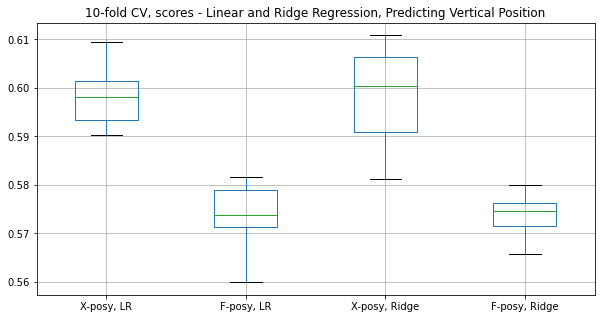

In [54]:
fig, ax = plt.subplots(figsize = (10, 5))
boxplot_pos = cv_scores.boxplot(column=['X-posy, LR', 'F-posy, LR', 'X-posy, Ridge', 'F-posy, Ridge'])  
boxplot_pos.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Vertical Position')

Text(0.5, 1.0, '10-fold CV, scores - Linear and Ridge Regression, Predicting Velocity')

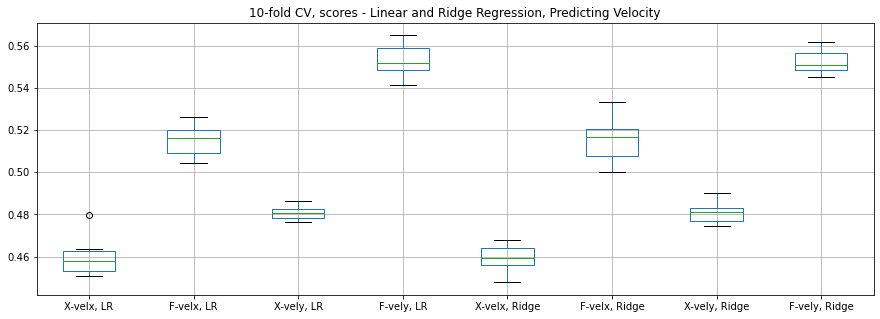

In [55]:
fig, ax = plt.subplots(figsize = (15, 5))
boxplot_vel = cv_scores.boxplot(column=['X-velx, LR', 'F-velx, LR','X-vely, LR', 'F-vely, LR', 'X-velx, Ridge', 
                                   'F-velx, Ridge','X-vely, Ridge', 'F-vely, Ridge'])  
boxplot_vel.set_title('10-fold CV, scores - Linear and Ridge Regression, Predicting Velocity')

In [56]:
f = {'CV':['AVERAGE SCORE' ], 
     'X-vel_x, LR': [np.mean(cv_scores_X_vel_x)] ,
     'F-vel_x, LR': [np.mean(cv_scores_F_vel_x)] ,
     'X-vel_y, LR': [np.mean(cv_scores_X_vel_y)] ,
     'F-vel_y, LR': [np.mean(cv_scores_F_vel_y)] ,
     'X-pos_x, LR': [np.mean(cv_scores_X_posx)] ,
     'F-pos_x, LR': [np.mean(cv_scores_F_posx)] , 
     'X-vel_x, Ridge': [np.mean(cv_scores_X_velx_r)],
     'F-vel_x, Ridge': [np.mean(cv_scores_F_velx_r)],  
     'X-vel_y, Ridge': [np.mean(cv_scores_X_vely_r)],
     'F-vel_y, Ridge': [np.mean(cv_scores_F_vely_r)],  
     'X-pos_x, Ridge': [np.mean(cv_scores_X_posx_r)],
     'F-pos_x, Ridge': [np.mean(cv_scores_F_posx_r)], 
     'X-pos_y, Ridge': [np.mean(cv_scores_X_posy_r)],
     'F-pos_y, Ridge': [np.mean(cv_scores_F_posy_r)], 
     'X-pos_y, LR': [np.mean(cv_scores_X_posy)] ,
     'F-pos_y, LR': [np.mean(cv_scores_F_posy)]
    }
pd.set_option('display.max_columns', None)
cv_scores_mean = pd.DataFrame(data=f)
cv_scores_mean

,CV,"X-vel_x, LR","F-vel_x, LR","X-vel_y, LR","F-vel_y, LR","X-pos_x, LR","F-pos_x, LR","X-vel_x, Ridge","F-vel_x, Ridge","X-vel_y, Ridge","F-vel_y, Ridge","X-pos_x, Ridge","F-pos_x, Ridge","X-pos_y, Ridge","F-pos_y, Ridge","X-pos_y, LR","F-pos_y, LR"
0,AVERAGE SCORE,0.459444,0.515334,0.480926,0.552547,0.545807,0.496972,0.459418,0.515238,0.480951,0.552553,0.545823,0.49707,0.598293,0.573714,0.598439,0.573671


In [57]:
# WITHOUT HISTORY USING LINEAR REGRESSION 
lr_only_rates = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_scores_F_vel_x ,
     'Vel_y': cv_scores_F_vel_y ,
     'Pos_x': cv_scores_F_posx ,
     'Pos_y': cv_scores_F_posy 
    }
pd.set_option('display.max_columns', None)
cv_scores_lr_rates = pd.DataFrame(data=lr_only_rates)
cv_scores_lr_rates

,K,Vel_x,Vel_y,Pos_x,Pos_y
0,1,0.514744,0.543443,0.491721,0.581670
1,2,0.516024,0.548333,0.486241,0.571521
2,3,0.507421,0.564809,0.489801,0.573506
3,4,0.516413,0.555600,0.494920,0.568009
4,5,0.525984,0.548129,0.492700,0.571135
5,6,0.521721,0.560083,0.495842,0.580309
6,7,0.507429,0.551426,0.503845,0.577440
7,8,0.518676,0.560503,0.504548,0.579393
8,9,0.504227,0.541233,0.514293,0.559859
9,10,0.520701,0.551913,0.495812,0.573871


In [58]:
lr_only_latents = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_scores_X_vel_x,
     'Vel_y': cv_scores_X_vel_y,
     'Pos_x': cv_scores_X_posx, 
     'Pos_y': cv_scores_X_posy
    }
pd.set_option('display.max_columns', None)
cv_scores_lr_latents = pd.DataFrame(data=lr_only_latents)
cv_scores_lr_latents

,K,Vel_x,Vel_y,Pos_x,Pos_y
0,1,0.462337,0.480234,0.550358,0.598177
1,2,0.452727,0.478110,0.537620,0.598010
2,3,0.454762,0.482397,0.548759,0.592074
3,4,0.451035,0.476531,0.553886,0.602094
4,5,0.457651,0.484561,0.553850,0.606653
5,6,0.451592,0.478326,0.546752,0.609535
6,7,0.458394,0.481327,0.543792,0.592446
7,8,0.479927,0.482677,0.538147,0.590362
8,9,0.463537,0.478817,0.552566,0.599043
9,10,0.462475,0.486284,0.532336,0.596001


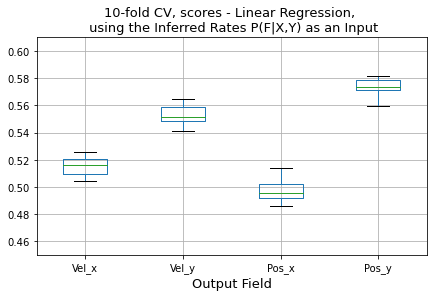

In [59]:
fig, ax = plt.subplots(figsize = (7, 4))
boxplot_final_rates = cv_scores_lr_rates.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_final_rates.set_title('10-fold CV, scores - Linear Regression, \n using the Inferred Rates P(F|X,Y) as an Input', fontsize=13)
boxplot_final_rates.set_ylim([0.45, 0.61])
boxplot_final_rates.set_xlabel('Output Field', fontsize=13)
plt.savefig('bGPFA_LR_scores_rates.jpeg')


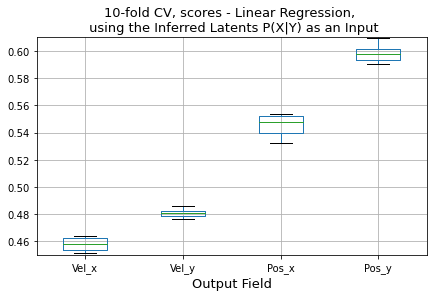

In [60]:
fig, ax = plt.subplots(figsize = (7, 4))
boxplot_final_pcs = cv_scores_lr_latents.boxplot(column=[ 'Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_final_pcs.set_title('10-fold CV, scores - Linear Regression, \n using the Inferred Latents P(X|Y) as an Input', fontsize=13)
boxplot_final_pcs.set_ylim([0.45, 0.61])
boxplot_final_pcs.set_xlabel('Output Field', fontsize=13)
plt.savefig('bGPFA_LR_scores_latents.jpeg')


COMPUTING PREDICTIONS 

In [53]:
model =  LinearRegression().fit(X[0:90000, :], locs[0:90000, :]) 
locs_pred = model.predict(X[90001:100000, :]) 
locs_pred.shape #(9999, 2)

(9999, 2)

Text(0, 0.5, 'y')

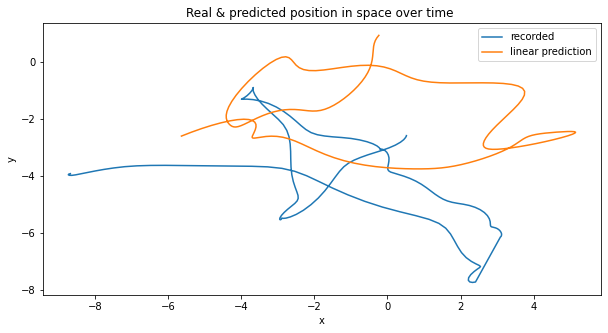

In [54]:
fig, ax = plt.subplots(figsize = (10, 5), nrows=1)

plt.plot(locs[90001:90200, 0], locs[90001:90200, 1]) 
plt.plot(locs_pred[0:199, 0], locs_pred[0:199, 1]) 
plt.title("Real & predicted position in space over time ")
plt.legend(["recorded","linear prediction"])
plt.xlabel("x")
plt.ylabel("y") 

BUILD MATRICES for HISTORY

In [94]:
# BUILD HISTORY ON LATENTS 
X.shape  # Time all trials x number of latents 

bins_before=5

X_hist_matrix=[[]]
for t in range (bins_before+1, len(X)): 
    X_hist=[]
    X_hist.append(X[t, :])
    X_hist.append(X[t-1, :])
    X_hist.append(X[t-2, :])
    X_hist.append(X[t-3, :])
    X_hist.append(X[t-4, :])
    X_hist.append(X[t-5, :])
    X_hist=np.reshape(X_hist, (1,(bins_before+1)*40))
    X_hist_matrix.append(X_hist)
X_hist_matrix.pop(0)
len(X_hist_matrix) #99994 
#len(np.transpose(X_hist_matrix)) #240
X_hist_matrix=np.squeeze(X_hist_matrix)
X_hist_matrix.shape #(99990, 400)

(99994, 240)

In [95]:
type(X) #numpy.ndarray
type(X_hist_matrix) #list
X_hist_matrix=np.array(X_hist_matrix)
type(X_hist_matrix)

numpy.ndarray

In [78]:
# BUILD HISTORY ON INFERRED RATES 
Ypred.shape  # Time all trials x number of latents 

bins_before=5

F_hist_matrix=[[]]
for t in range (bins_before+1, len(X)): 
    F_hist=[]
    F_hist.append(Ypred[t, :])
    F_hist.append(Ypred[t-1, :])
    F_hist.append(Ypred[t-2, :])
    F_hist.append(Ypred[t-3, :])
    F_hist.append(Ypred[t-4, :])
    F_hist.append(Ypred[t-5, :])
    F_hist=np.reshape(F_hist, (1,(bins_before+1)*77))
    F_hist_matrix.append(F_hist)
F_hist_matrix.pop(0)
len(F_hist_matrix) #99994 
#len(np.transpose(X_hist_matrix)) #240
F_hist_matrix=np.squeeze(F_hist_matrix)
F_hist_matrix.shape #(99990, 400)

(99994, 462)

In [79]:
type(Ypred) #numpy.ndarray
type(F_hist_matrix) #list
F_hist_matrix=np.array(F_hist_matrix)
type(F_hist_matrix)

numpy.ndarray

In [80]:
pos_for_history=[[]]
pos_row=locs[6:,:]
pos_for_history.append(pos_row)
pos_for_history.pop(0)
len(pos_for_history) #1
#len(np.transpose(pos_for_history)) #2
locs_hist=pos_for_history[0][:, :]
locs_hist.shape #(99990, 2)

type(locs_hist)
locs_hist.shape

vel_for_history=[[]]
vel_row=vel[6:,:]
vel_for_history.append(vel_row)
vel_for_history.pop(0)
len(vel_for_history) #1
#len(np.transpose(pos_for_history)) #2
vel_hist=vel_for_history[0][:, :]
vel_hist.shape #(99990, 2)

type(vel_hist)
vel_hist.shape

(99994, 2)

RIDGE OPTIMISATION

In [60]:
import numpy as np
import scipy.stats
from scipy.linalg import null_space, orth

import pyaldata
#import pysubspaces.utils

from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold

#from beneuro.reduced_rank import ReducedRankRegressor

import warnings

from tqdm.auto import tqdm


def ridge_alpha_range(X, dmax_scales, z_score=False):
    """
    Determine the appropriate range for the ridge regularization parameter alpha based on the source data X
    Parameters
    ----------
    X : xr.DataArray
        source activities in ridge regression
    dmax_scales : array of floats
        list of scaling factors for the largest eigenvalue
        e.g. np.linspace(0.5, 1, n_alphas)
    z_score : bool, default False
        divide by the standard deviation of the activities or not
    Returns
    -------
    alpha_range : np.ndarray
        list of alpha values to try when doing cross-validation
    """
    dmax_scales = np.array(dmax_scales)

    if z_score:
        Z = pyaldata.z_score(X)
    else:
        Z = pyaldata.center(X)

    dmax = np.max(np.linalg.eigvals(Z.T @ Z))
    alpha_range = dmax * (1 - dmax_scales) / dmax_scales

    return alpha_range

In [61]:
from sklearn.metrics import r2_score, accuracy_score, make_scorer



In [62]:
def semedo_opt_alpha(alpha_range, cv_scores):
    """
    Select the optimal alpha parameter for ridge regression based on
    cross-validated test scores.
    Select the simplest model with test performance within 1 SEM of the highest test performance.
    Parameters
    ----------
    alpha_range : array-like
        candidate alpha values
    cv_scores : array-like
        cross-validated test scores corresponding
        to the values in alpha_range
    Returns
    -------
    optimal alpha : float
    """
    means = [np.mean(sc) for sc in cv_scores]

    max_score = np.max(means)
    max_score_sem = scipy.stats.sem(cv_scores[np.argmax(means)])

    # see which elements are within 1 SEM of the max score
    mask = means > (max_score - max_score_sem)

    # sort in ascending order and take the largest alpha ~ simplest model
    return np.max(alpha_range[mask])

In [63]:
def fit_semedo_ridge(X, y, n_alpha=100, selection='semedo', cv=KFold(10, shuffle=True)):
    """
    Fit a ridge regression model by first finding the range of alpha values based on the input data,
    then select the best regressor using the method outlined in Semedo et al 2019
    Parameters
    ----------
    X : 2D np.array
        input data
        shape: n_samples x n_features
    y : np.array
        target values
    n_alpha : int, optional, default 100
        number of alpha values to try
    selection : str
        method to select the final alpha
        'semedo' or 'naive'
    cv : int or KFold
        cross-validation option to pass to cross_val_score
    Returns
    -------
    ridge : sklearn.linear_model.Ridge
        regressor fitted to X and y using the optimal alpha value
    """
    candidate_alphas = ridge_alpha_range(X, np.linspace(0.5, 1., n_alpha))
    candidate_alphas = np.real(candidate_alphas)
    default_scorer = make_scorer(r2_score, multioutput = 'variance_weighted')
    cv_scores = [cross_val_score(Ridge(alpha), X, y, cv = cv, scoring=default_scorer)
                 for alpha in tqdm(candidate_alphas)]
    if selection == 'semedo':
        opt_alpha = np.real(semedo_opt_alpha(candidate_alphas, cv_scores))
    else:
        opt_alpha = np.real(naive_opt_alpha(candidate_alphas, cv_scores))
    
    return Ridge(opt_alpha).fit(X, y)

In [166]:
# Ridge Optimisation to use optimal values of alpha for all input-output combinations 

# choose input argument 1 among X, Ypred, X_hist_matrix, F_hist_matrix
# choose input argument 2 among vel, locs[:, 0], locs[:, 1], vel_hist, locs_hist[:, 0], locs_hist[:, 1]


#regressor=fit_semedo_ridge(Ypred, locs[:, 0], n_alpha=100, selection='semedo', cv=KFold(10, shuffle=True))
regressor #Ridge(alpha=0.0)

Ridge(alpha=0.0)

CROSS VALIDATION

In [81]:
cv_scores_X_hist_velx = cross_val_score(LinearRegression(), X_hist_matrix, vel_hist[:,0], cv = KFold(10, shuffle=True))
cv_scores_X_hist_vely = cross_val_score(LinearRegression(), X_hist_matrix, vel_hist[:,1], cv = KFold(10, shuffle=True))
cv_scores_X_hist_posx = cross_val_score(LinearRegression(), X_hist_matrix, locs_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_hist_posy = cross_val_score(LinearRegression(), X_hist_matrix, locs_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_X_hist_velx_r = cross_val_score(Ridge(alpha=1e-9), X_hist_matrix, vel_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_hist_vely_r = cross_val_score(Ridge(alpha=1e-9), X_hist_matrix, vel_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_X_hist_posx_r = cross_val_score(Ridge(alpha=1e-9), X_hist_matrix, locs_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_X_hist_posy_r = cross_val_score(Ridge(alpha=1e-9), X_hist_matrix, locs_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_hist_velx = cross_val_score(LinearRegression(), F_hist_matrix, vel_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_hist_vely = cross_val_score(LinearRegression(), F_hist_matrix, vel_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_hist_posx = cross_val_score(LinearRegression(), F_hist_matrix, locs_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_hist_posy = cross_val_score(LinearRegression(), F_hist_matrix, locs_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_hist_velx_r = cross_val_score(Ridge(alpha=1e-9), F_hist_matrix, vel_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_hist_vely_r = cross_val_score(Ridge(alpha=1e-9), F_hist_matrix, vel_hist[:, 1], cv = KFold(10, shuffle=True))
cv_scores_F_hist_posx_r = cross_val_score(Ridge(alpha=1e-9), F_hist_matrix, locs_hist[:, 0], cv = KFold(10, shuffle=True))
cv_scores_F_hist_posy_r = cross_val_score(Ridge(alpha=1e-9), F_hist_matrix, locs_hist[:, 1], cv = KFold(10, shuffle=True))

/home/md5218/mambaforge/envs/neuro_data/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.89369e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/md5218/mambaforge/envs/neuro_data/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.47399e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/md5218/mambaforge/envs/neuro_data/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.82402e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/md5218/mambaforge/envs/neuro_data/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.80548e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, 

In [82]:
f = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'X-vel_x, LR': cv_scores_X_hist_velx ,
     'X-vel_y, LR': cv_scores_X_hist_vely ,
     'X-pos_x, LR': cv_scores_X_hist_posx ,
     'X-pos_y, LR': cv_scores_X_hist_posy ,
     'X-vel_x, Ridge': cv_scores_X_hist_velx_r,
     'X-vel_y, Ridge': cv_scores_X_hist_vely_r,
     'X-pos_x, Ridge': cv_scores_X_hist_posx_r,
     'X-pos_y, Ridge': cv_scores_X_hist_posy_r ,
     'F-vel_x, LR': cv_scores_F_hist_velx ,
     'F-vel_y, LR': cv_scores_F_hist_vely ,
     'F-pos_x, LR': cv_scores_F_hist_posx ,
     'F-pos_y, LR': cv_scores_F_hist_posy ,
     'F-vel_x, Ridge': cv_scores_F_hist_velx_r,
     'F-vel_y, Ridge': cv_scores_F_hist_vely_r,
     'F-pos_x, Ridge': cv_scores_F_hist_posx_r,
     'F-pos_y, Ridge': cv_scores_F_hist_posy_r 
    }
pd.set_option('display.max_columns', None)
cv_scores_hist = pd.DataFrame(data=f)
cv_scores_hist

,K,"X-vel_x, LR","X-vel_y, LR","X-pos_x, LR","X-pos_y, LR","X-vel_x, Ridge","X-vel_y, Ridge","X-pos_x, Ridge","X-pos_y, Ridge","F-vel_x, LR","F-vel_y, LR","F-pos_x, LR","F-pos_y, LR","F-vel_x, Ridge","F-vel_y, Ridge","F-pos_x, Ridge","F-pos_y, Ridge"
0,1,0.631013,0.631586,0.653307,0.705466,0.602598,0.630715,0.647026,0.716934,0.624191,0.654293,0.569654,0.651433,0.634658,0.653531,0.574258,0.645013
1,2,0.622708,0.633115,0.649775,0.690899,0.628351,0.628718,0.654051,0.692578,0.619838,0.652871,0.573441,0.659945,0.623090,0.659731,0.556689,0.644217
2,3,0.600461,0.637635,0.640802,0.700281,0.619005,0.633787,0.633133,0.701461,0.627115,0.665319,0.566571,0.646571,0.633540,0.648616,0.569984,0.641837
3,4,0.614927,0.633363,0.656614,0.706446,0.610187,0.634201,0.643328,0.698858,0.635367,0.651276,0.561634,0.654580,0.629082,0.657558,0.570539,0.651477
4,5,0.622491,0.637463,0.646544,0.702746,0.618707,0.631647,0.651707,0.697602,0.629001,0.648573,0.561306,0.649103,0.619772,0.667419,0.556451,0.659786
5,6,0.628261,0.638799,0.643453,0.709489,0.613053,0.639844,0.651122,0.708273,0.632493,0.660356,0.563944,0.647835,0.633493,0.650029,0.559951,0.653237
6,7,0.604703,0.643094,0.647517,0.705447,0.609999,0.639448,0.646781,0.695121,0.624869,0.644541,0.563228,0.652183,0.632224,0.654649,0.568539,0.657959
7,8,0.618406,0.630856,0.651953,0.701615,0.617576,0.631019,0.644095,0.693440,0.629267,0.647955,0.568175,0.639591,0.628547,0.655499,0.562585,0.659447
8,9,0.609616,0.636550,0.650739,0.705766,0.601895,0.630256,0.638409,0.706302,0.623372,0.656016,0.573675,0.658913,0.623275,0.639873,0.571737,0.643415
9,10,0.611340,0.624807,0.643371,0.704945,0.626066,0.638234,0.641759,0.704655,0.631499,0.652027,0.563723,0.642429,0.618913,0.647944,0.574941,0.647005


In [83]:
f = {'CV':['AVERAGE SCORE' ], 
     'Latents-vel_x, LR': [np.mean(cv_scores_X_hist_velx)] ,
     'Latents-vel_y, LR': [np.mean(cv_scores_X_hist_vely)] ,
     'Latents-pos_x, LR': [np.mean(cv_scores_X_hist_posx)] ,
     'Latents-pos_y, LR': [np.mean(cv_scores_X_hist_posy)] ,
     'Latents-vel_x, Ridge': [np.mean(cv_scores_X_hist_velx_r)],
     'Latents-vel_y, Ridge': [np.mean(cv_scores_X_hist_vely_r)],
     'Latents-pos_x, Ridge': [np.mean(cv_scores_X_hist_posx_r)],
     'Latents-pos_y, Ridge': [np.mean(cv_scores_X_hist_posy_r)],
     'Rates-vel_x, LR': [np.mean(cv_scores_F_hist_velx)] ,
     'Rates-vel_y, LR': [np.mean(cv_scores_F_hist_vely)] ,
     'Rates-pos_x, LR': [np.mean(cv_scores_F_hist_posx)] ,
     'Rates-pos_y, LR': [np.mean(cv_scores_F_hist_posy)] ,
     'Rates-vel_x, Ridge': [np.mean(cv_scores_F_hist_velx_r)],
     'Rates-vel_y, Ridge': [np.mean(cv_scores_F_hist_vely_r)],
     'Rates-pos_x, Ridge': [np.mean(cv_scores_F_hist_posx_r)],
     'Rates-pos_y, Ridge': [np.mean(cv_scores_F_hist_posy_r)]
    }
pd.set_option('display.max_columns', None)
cv_scores_hist_mean = pd.DataFrame(data=f)
cv_scores_hist_mean

,CV,"Latents-vel_x, LR","Latents-vel_y, LR","Latents-pos_x, LR","Latents-pos_y, LR","Latents-vel_x, Ridge","Latents-vel_y, Ridge","Latents-pos_x, Ridge","Latents-pos_y, Ridge","Rates-vel_x, LR","Rates-vel_y, LR","Rates-pos_x, LR","Rates-pos_y, LR","Rates-vel_x, Ridge","Rates-vel_y, Ridge","Rates-pos_x, Ridge","Rates-pos_y, Ridge"
0,AVERAGE SCORE,0.616393,0.634727,0.648408,0.70331,0.614744,0.633787,0.645141,0.701522,0.627701,0.653323,0.566535,0.650258,0.627659,0.653485,0.566567,0.650339


Text(0.5, 1.0, '10-fold CV, scores - Linear and Ridge Regression, Using Latents With History')

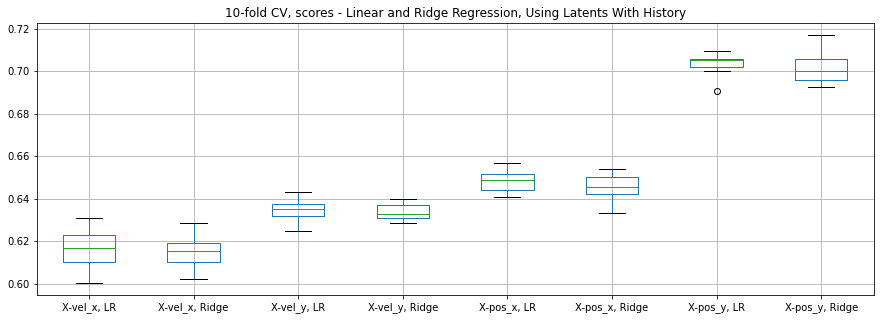

In [84]:
fig, ax = plt.subplots(figsize = (15, 5))
boxplot = cv_scores_hist.boxplot(column=['X-vel_x, LR', 'X-vel_x, Ridge','X-vel_y, LR', 'X-vel_y, Ridge','X-pos_x, LR', 'X-pos_x, Ridge','X-pos_y, LR', 'X-pos_y, Ridge'])  
boxplot.set_title('10-fold CV, scores - Linear and Ridge Regression, Using Latents With History')

In [85]:
# WITH HISTORY USING LINEAR REGRESSION 
lr_only_hist_rates = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_scores_F_hist_velx ,
     'Vel_y': cv_scores_F_hist_vely ,
     'Pos_x': cv_scores_F_hist_posx ,
     'Pos_y': cv_scores_F_hist_posy 
    }
pd.set_option('display.max_columns', None)
cv_scores_lr_hist_rates = pd.DataFrame(data=lr_only_hist_rates)
cv_scores_lr_hist_rates

,K,Vel_x,Vel_y,Pos_x,Pos_y
0,1,0.624191,0.654293,0.569654,0.651433
1,2,0.619838,0.652871,0.573441,0.659945
2,3,0.627115,0.665319,0.566571,0.646571
3,4,0.635367,0.651276,0.561634,0.654580
4,5,0.629001,0.648573,0.561306,0.649103
5,6,0.632493,0.660356,0.563944,0.647835
6,7,0.624869,0.644541,0.563228,0.652183
7,8,0.629267,0.647955,0.568175,0.639591
8,9,0.623372,0.656016,0.573675,0.658913
9,10,0.631499,0.652027,0.563723,0.642429


In [86]:
lr_only_hist_latents = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_scores_X_hist_velx,
     'Vel_y': cv_scores_X_hist_vely,
     'Pos_x': cv_scores_X_hist_posx, 
     'Pos_y': cv_scores_X_hist_posy
    }
pd.set_option('display.max_columns', None)
cv_scores_lr_hist_latents = pd.DataFrame(data=lr_only_hist_latents)
cv_scores_lr_hist_latents

,K,Vel_x,Vel_y,Pos_x,Pos_y
0,1,0.631013,0.631586,0.653307,0.705466
1,2,0.622708,0.633115,0.649775,0.690899
2,3,0.600461,0.637635,0.640802,0.700281
3,4,0.614927,0.633363,0.656614,0.706446
4,5,0.622491,0.637463,0.646544,0.702746
5,6,0.628261,0.638799,0.643453,0.709489
6,7,0.604703,0.643094,0.647517,0.705447
7,8,0.618406,0.630856,0.651953,0.701615
8,9,0.609616,0.636550,0.650739,0.705766
9,10,0.611340,0.624807,0.643371,0.704945


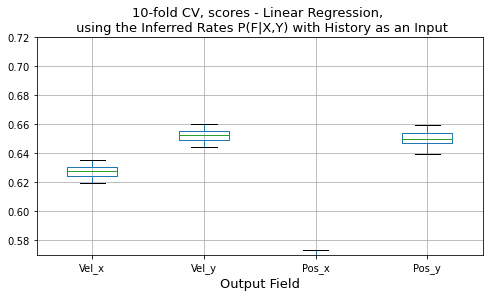

In [87]:
fig, ax = plt.subplots(figsize = (8, 4))
boxplot_hist_rates = cv_scores_lr_hist_rates.boxplot(column=['Vel_x','Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_hist_rates.set_title('10-fold CV, scores - Linear Regression, \n using the Inferred Rates P(F|X,Y) with History as an Input', fontsize=13)
boxplot_hist_rates.set_ylim([0.57, 0.72])
boxplot_hist_rates.set_xlabel('Output Field', fontsize=13)
plt.savefig('bGPFA_LR_scores_rates_hist.jpeg')


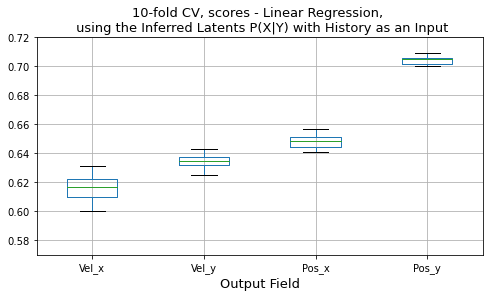

In [88]:
fig, ax = plt.subplots(figsize = (8, 4))
boxplot_final_pcs = cv_scores_lr_hist_latents.boxplot(column=['Vel_x','Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_final_pcs.set_title('10-fold CV, scores - Linear Regression, \n using the Inferred Latents P(X|Y) with History as an Input', fontsize=13)
boxplot_final_pcs.set_ylim([0.57, 0.72])
boxplot_final_pcs.set_xlabel('Output Field', fontsize=13)
plt.savefig('bGPFA_LR_scores_latents_hist.jpeg')


COMPUTING PREDICTIONS

In [97]:
model_latents =  LinearRegression().fit(X_hist_matrix[0:90000, :], locs_hist[0:90000, :]) 
locs_pred_hist = model_latents.predict(X_hist_matrix[90001:, :]) 
#locs_pred_hist.shape #(9993, 2)
y_test_lr=locs_hist[90000:, :]

model_rates =  LinearRegression().fit(F_hist_matrix[0:90000, :], locs_hist[0:90000, :]) 
locs_pred_hist_rates = model_rates.predict(F_hist_matrix[90001:, :]) 

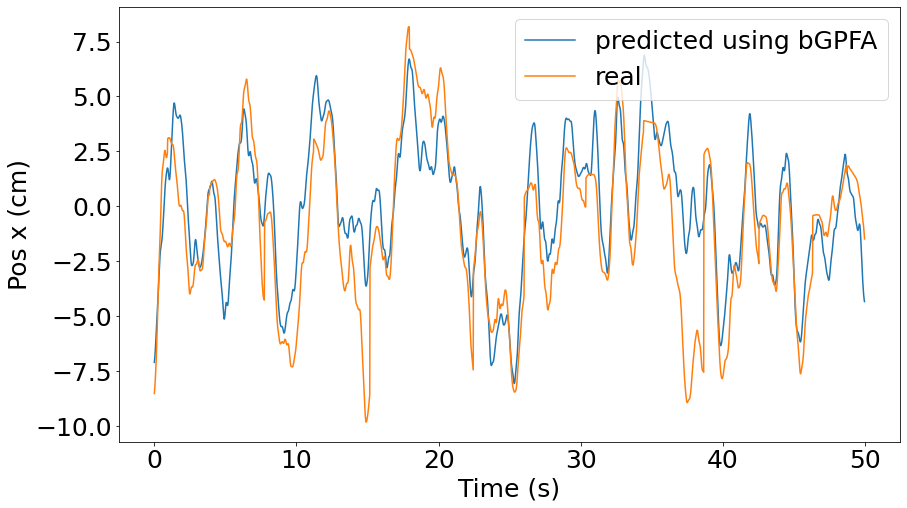

In [101]:
time=0.02*np.arange(len(y_test_lr[0:2500, 0]))

fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, locs_pred_hist[0:2500, 0]) 
plt.plot(time, y_test_lr[0:2500, 0])
plt.legend(['predicted using bGPFA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n linear regression based on latents inferred by bGPFA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LR_pos_x_bGPFA.jpeg')

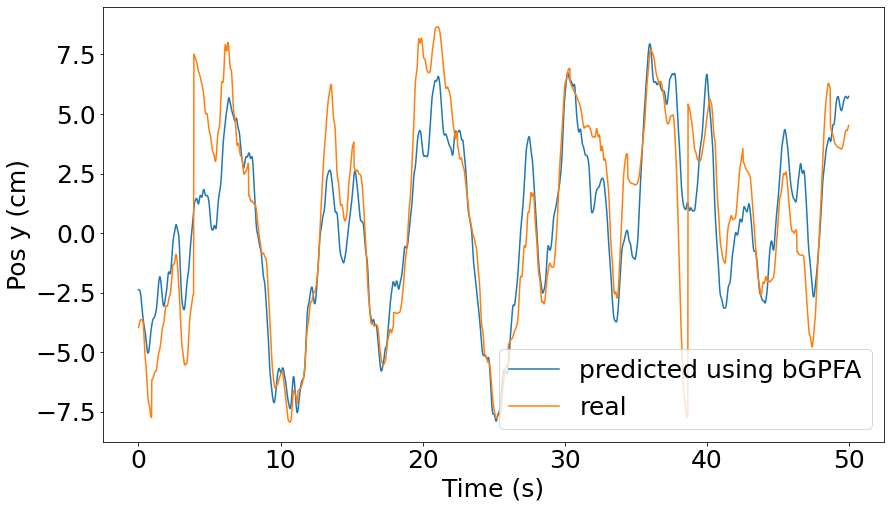

In [102]:
time=0.02*np.arange(len(y_test_lr[0:2500, 0]))

fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, locs_pred_hist[0:2500, 1]) 
plt.plot(time, y_test_lr[0:2500, 1])
plt.legend(['predicted using bGPFA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
#plt.title('Real & predicted hand position in y for 25% of testing data: \n linear regression based on latents inferred by bGPFA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LR_pos_y_bGPFA.jpeg')

Text(0.5, 1.0, 'Hand position in x for 35-40% testing data')

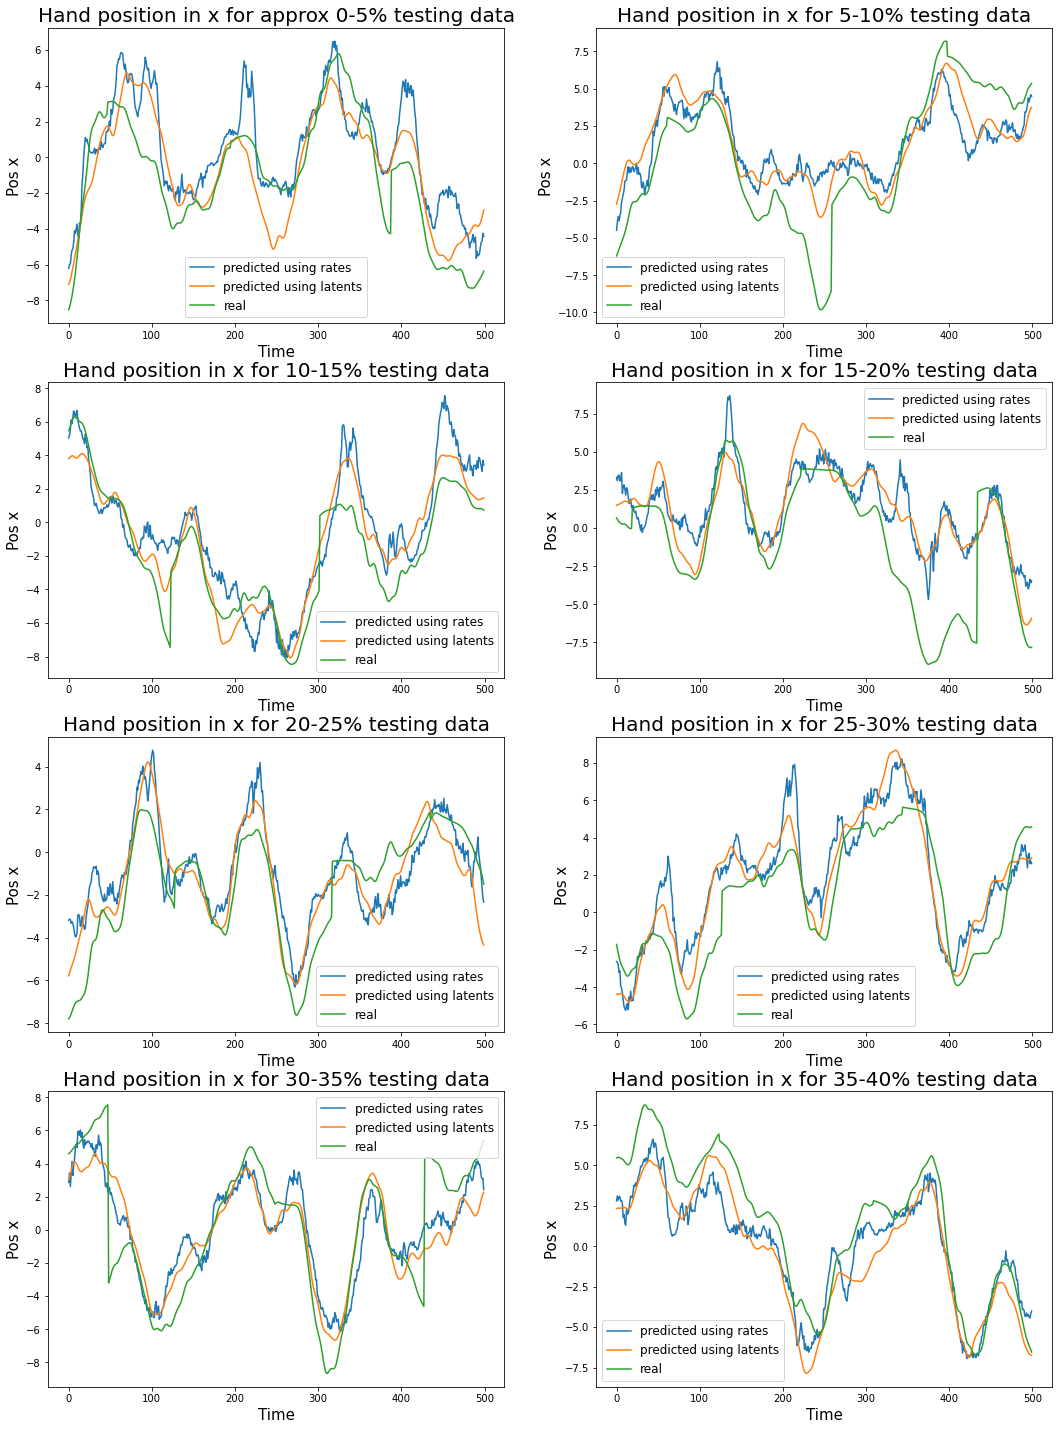

In [73]:
fig, ax = plt.subplots(figsize = (18, 25), nrows=4, ncols=2)
ax[0][0].plot(locs_pred_hist_rates[0:500, 0]) 
ax[0][0].plot(locs_pred_hist[0:500, 0]) 
ax[0][0].plot(y_test_lr[0:500, 0])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos x', fontsize=15)
ax[0][0].set_title('Hand position in x for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(locs_pred_hist_rates[500:1000, 0])
ax[0][1].plot(locs_pred_hist[500:1000, 0]) 
ax[0][1].plot(y_test_lr[500:1000, 0])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos x', fontsize=15)
ax[0][1].set_title('Hand position in x for 5-10% testing data', fontsize=20)
ax[1][0].plot(locs_pred_hist_rates[1000:1500, 0]) 
ax[1][0].plot(locs_pred_hist[1000:1500, 0]) 
ax[1][0].plot(y_test_lr[1000:1500, 0])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos x', fontsize=15)
ax[1][0].set_title('Hand position in x for 10-15% testing data', fontsize=20)
ax[1][1].plot(locs_pred_hist_rates[1500:2000, 0]) 
ax[1][1].plot(locs_pred_hist[1500:2000, 0]) 
ax[1][1].plot(y_test_lr[1500:2000, 0])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos x', fontsize=15)
ax[1][1].set_title('Hand position in x for 15-20% testing data', fontsize=20)
ax[2][0].plot(locs_pred_hist_rates[2000:2500, 0]) 
ax[2][0].plot(locs_pred_hist[2000:2500, 0]) 
ax[2][0].plot(y_test_lr[2000:2500, 0])
ax[2][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[2][0].set_xlabel('Time', fontsize=15)
ax[2][0].set_ylabel('Pos x', fontsize=15)
ax[2][0].set_title('Hand position in x for 20-25% testing data', fontsize=20)
ax[2][1].plot(locs_pred_hist_rates[2500:3000, 0]) 
ax[2][1].plot(locs_pred_hist[2500:3000, 0]) 
ax[2][1].plot(y_test_lr[2500:3000, 0])
ax[2][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[2][1].set_xlabel('Time', fontsize=15)
ax[2][1].set_ylabel('Pos x', fontsize=15)
ax[2][1].set_title('Hand position in x for 25-30% testing data', fontsize=20)
ax[3][0].plot(locs_pred_hist_rates[3000:3500, 0]) 
ax[3][0].plot(locs_pred_hist[3000:3500, 0]) 
ax[3][0].plot(y_test_lr[3000:3500, 0])
ax[3][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[3][0].set_xlabel('Time', fontsize=15)
ax[3][0].set_ylabel('Pos x', fontsize=15)
ax[3][0].set_title('Hand position in x for 30-35% testing data', fontsize=20)
ax[3][1].plot(locs_pred_hist_rates[3500:4000, 0])
ax[3][1].plot(locs_pred_hist[3500:4000, 0]) 
ax[3][1].plot(y_test_lr[3500:4000, 0])
ax[3][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[3][1].set_xlabel('Time', fontsize=15)
ax[3][1].set_ylabel('Pos x', fontsize=15)
ax[3][1].set_title('Hand position in x for 35-40% testing data', fontsize=20)

Text(0.5, 1.0, 'Hand position in y for 35-40% testing data')

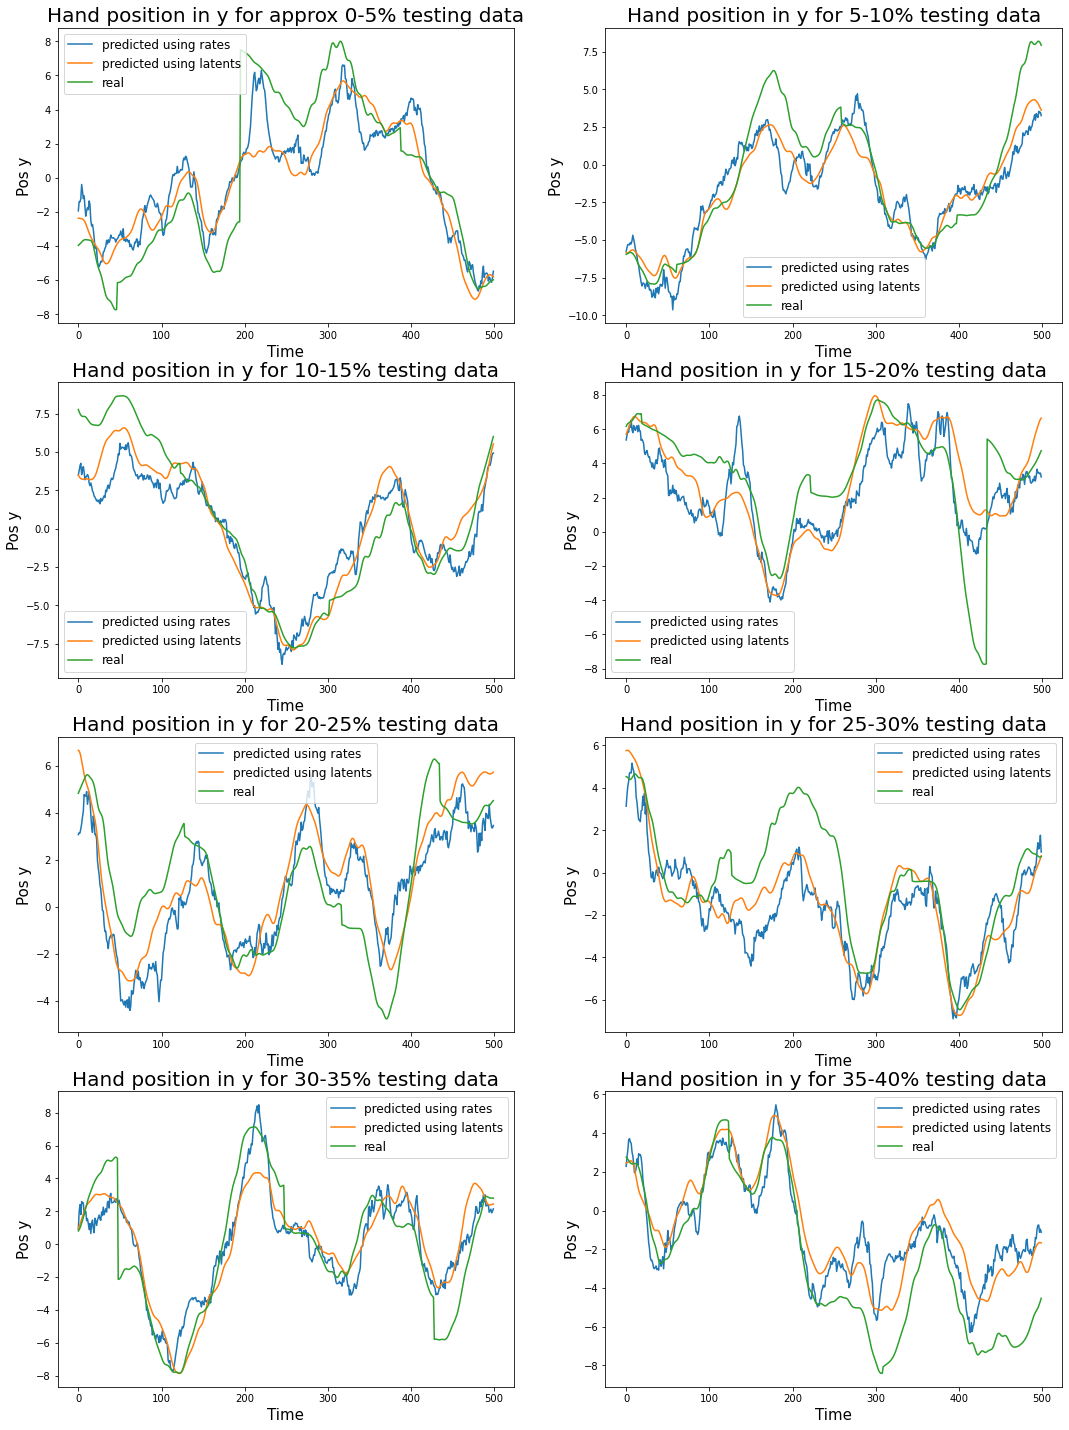

In [74]:
fig, ax = plt.subplots(figsize = (18, 25), nrows=4, ncols=2)
ax[0][0].plot(locs_pred_hist_rates[0:500, 1]) 
ax[0][0].plot(locs_pred_hist[0:500, 1]) 
ax[0][0].plot(y_test_lr[0:500, 1])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos y', fontsize=15)
ax[0][0].set_title('Hand position in y for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(locs_pred_hist_rates[500:1000, 1])
ax[0][1].plot(locs_pred_hist[500:1000, 1]) 
ax[0][1].plot(y_test_lr[500:1000, 1])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos y', fontsize=15)
ax[0][1].set_title('Hand position in y for 5-10% testing data', fontsize=20)
ax[1][0].plot(locs_pred_hist_rates[1000:1500, 1]) 
ax[1][0].plot(locs_pred_hist[1000:1500, 1]) 
ax[1][0].plot(y_test_lr[1000:1500, 1])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos y', fontsize=15)
ax[1][0].set_title('Hand position in y for 10-15% testing data', fontsize=20)
ax[1][1].plot(locs_pred_hist_rates[1500:2000, 1]) 
ax[1][1].plot(locs_pred_hist[1500:2000, 1]) 
ax[1][1].plot(y_test_lr[1500:2000, 1])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos y', fontsize=15)
ax[1][1].set_title('Hand position in y for 15-20% testing data', fontsize=20)
ax[2][0].plot(locs_pred_hist_rates[2000:2500, 1]) 
ax[2][0].plot(locs_pred_hist[2000:2500, 1]) 
ax[2][0].plot(y_test_lr[2000:2500, 1])
ax[2][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[2][0].set_xlabel('Time', fontsize=15)
ax[2][0].set_ylabel('Pos y', fontsize=15)
ax[2][0].set_title('Hand position in y for 20-25% testing data', fontsize=20)
ax[2][1].plot(locs_pred_hist_rates[2500:3000, 1]) 
ax[2][1].plot(locs_pred_hist[2500:3000, 1]) 
ax[2][1].plot(y_test_lr[2500:3000, 1])
ax[2][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[2][1].set_xlabel('Time', fontsize=15)
ax[2][1].set_ylabel('Pos y', fontsize=15)
ax[2][1].set_title('Hand position in y for 25-30% testing data', fontsize=20)
ax[3][0].plot(locs_pred_hist_rates[3000:3500, 1]) 
ax[3][0].plot(locs_pred_hist[3000:3500, 1]) 
ax[3][0].plot(y_test_lr[3000:3500, 1])
ax[3][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[3][0].set_xlabel('Time', fontsize=15)
ax[3][0].set_ylabel('Pos y', fontsize=15)
ax[3][0].set_title('Hand position in y for 30-35% testing data', fontsize=20)
ax[3][1].plot(locs_pred_hist_rates[3500:4000, 1])
ax[3][1].plot(locs_pred_hist[3500:4000, 1]) 
ax[3][1].plot(y_test_lr[3500:4000, 1])
ax[3][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[3][1].set_xlabel('Time', fontsize=15)
ax[3][1].set_ylabel('Pos y', fontsize=15)
ax[3][1].set_title('Hand position in y for 35-40% testing data', fontsize=20)

Text(0, 0.5, 'y')

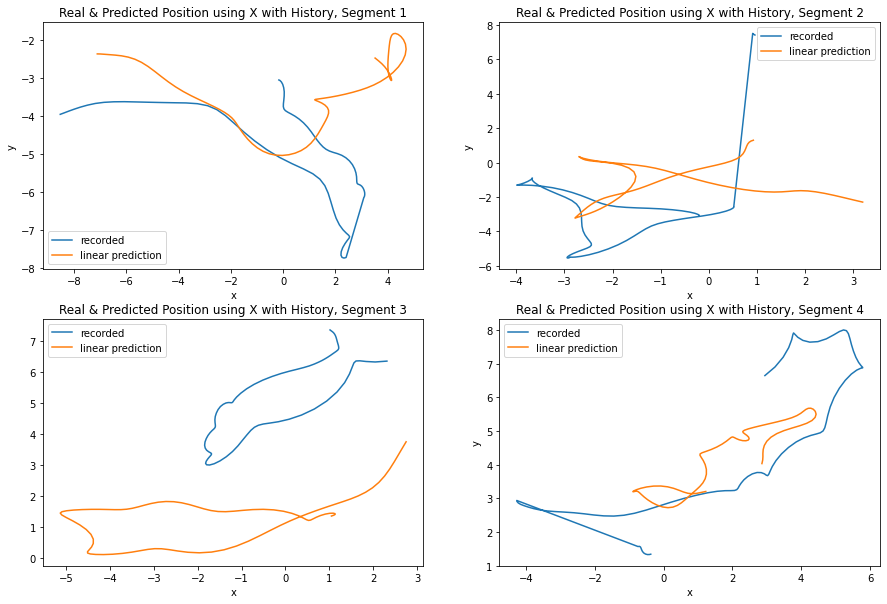

In [75]:
fig, ax = plt.subplots(figsize = (15, 10), nrows=2, ncols=2)

ax[0][0].plot(locs_hist[90000:90099, 0], locs_hist[90000:90099, 1]) 
ax[0][0].plot(locs_pred_hist[0:99, 0], locs_pred_hist[0:99, 1]) 
ax[0][0].set_title("Real & Predicted Position using X with History, Segment 1")
ax[0][0].legend(["recorded","linear prediction"])
ax[0][0].set_xlabel("x")
ax[0][0].set_ylabel("y")
ax[0][1].plot(locs_hist[90100:90199, 0], locs_hist[90100:90199, 1]) 
ax[0][1].plot(locs_pred_hist[100:199, 0], locs_pred_hist[100:199, 1]) 
ax[0][1].set_title("Real & Predicted Position using X with History, Segment 2")
ax[0][1].legend(["recorded","linear prediction"])
ax[0][1].set_xlabel("x")
ax[0][1].set_ylabel("y")
ax[1][0].plot(locs_hist[90200:90299, 0], locs_hist[90200:90299, 1]) 
ax[1][0].plot(locs_pred_hist[200:299, 0], locs_pred_hist[200:299, 1]) 
ax[1][0].set_title("Real & Predicted Position using X with History, Segment 3")
ax[1][0].legend(["recorded","linear prediction"])
ax[1][0].set_xlabel("x")
ax[1][1].set_ylabel("y")
ax[1][1].plot(locs_hist[90300:90399, 0], locs_hist[90300:90399, 1]) 
ax[1][1].plot(locs_pred_hist[300:399, 0], locs_pred_hist[300:399, 1]) 
ax[1][1].set_title("Real & Predicted Position using X with History, Segment 4")
ax[1][1].legend(["recorded","linear prediction"])
ax[1][1].set_xlabel("x")
ax[1][1].set_ylabel("y")

Text(0, 0.5, 'y')

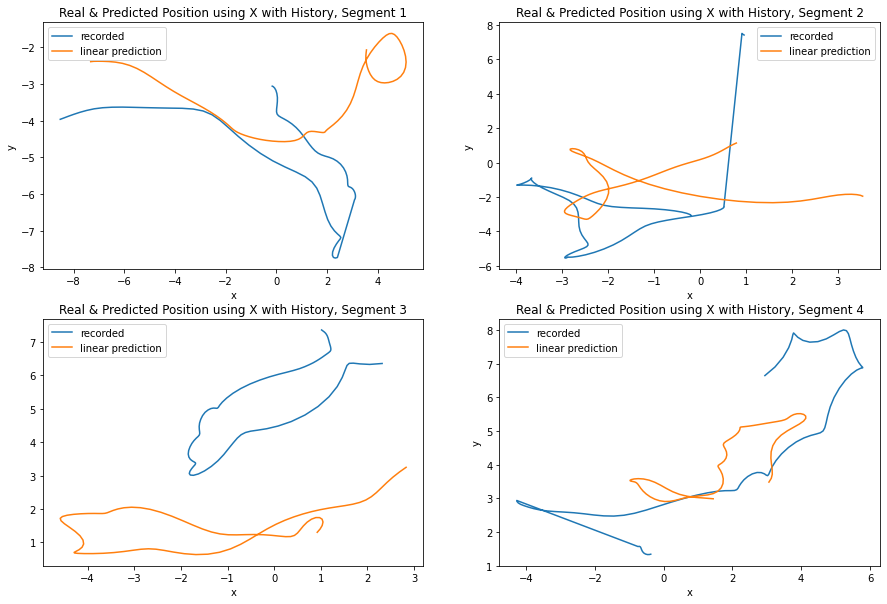

In [76]:
model =  Ridge(alpha=1e-7).fit(X_hist_matrix[0:90000, :], locs_hist[0:90000, :]) 
locs_pred_hist = model.predict(X_hist_matrix[90001:, :]) 
locs_pred_hist.shape #(9993, 2)

fig, ax = plt.subplots(figsize = (15, 10), nrows=2, ncols=2)

ax[0][0].plot(locs_hist[90000:90099, 0], locs_hist[90000:90099, 1]) 
ax[0][0].plot(locs_pred_hist[0:99, 0], locs_pred_hist[0:99, 1]) 
ax[0][0].set_title("Real & Predicted Position using X with History, Segment 1")
ax[0][0].legend(["recorded","linear prediction"])
ax[0][0].set_xlabel("x")
ax[0][0].set_ylabel("y")
ax[0][1].plot(locs_hist[90100:90199, 0], locs_hist[90100:90199, 1]) 
ax[0][1].plot(locs_pred_hist[100:199, 0], locs_pred_hist[100:199, 1]) 
ax[0][1].set_title("Real & Predicted Position using X with History, Segment 2")
ax[0][1].legend(["recorded","linear prediction"])
ax[0][1].set_xlabel("x")
ax[0][1].set_ylabel("y")
ax[1][0].plot(locs_hist[90200:90299, 0], locs_hist[90200:90299, 1]) 
ax[1][0].plot(locs_pred_hist[200:299, 0], locs_pred_hist[200:299, 1]) 
ax[1][0].set_title("Real & Predicted Position using X with History, Segment 3")
ax[1][0].legend(["recorded","linear prediction"])
ax[1][0].set_xlabel("x")
ax[1][1].set_ylabel("y")
ax[1][1].plot(locs_hist[90300:90399, 0], locs_hist[90300:90399, 1]) 
ax[1][1].plot(locs_pred_hist[300:399, 0], locs_pred_hist[300:399, 1]) 
ax[1][1].set_title("Real & Predicted Position using X with History, Segment 4")
ax[1][1].legend(["recorded","linear prediction"])
ax[1][1].set_xlabel("x")
ax[1][1].set_ylabel("y")

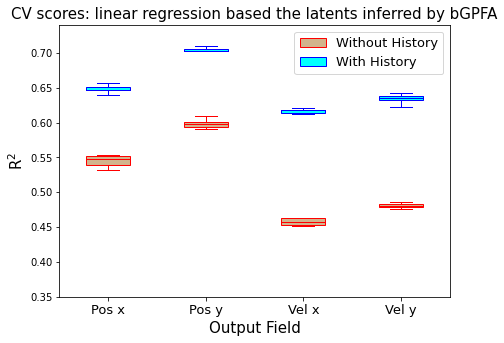

In [75]:
import matplotlib.pyplot as plt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

cv_latents_bGPFA = [cv_scores_X_posx, cv_scores_X_posy, cv_scores_X_vel_x, cv_scores_X_vel_y]
cv_latents_bGPFA_hist = [cv_scores_X_hist_posx,cv_scores_X_hist_posy, cv_scores_X_hist_velx, cv_scores_X_hist_vely ]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_latents_bGPFA, 'red', 'tan')
bp2 = box_plot(cv_latents_bGPFA_hist, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Without History', 'With History'], fontsize=13)
ax.set_ylim(0.35, 0.74)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: linear regression based the latents inferred by bGPFA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LR_scores_bGPFA.jpeg')

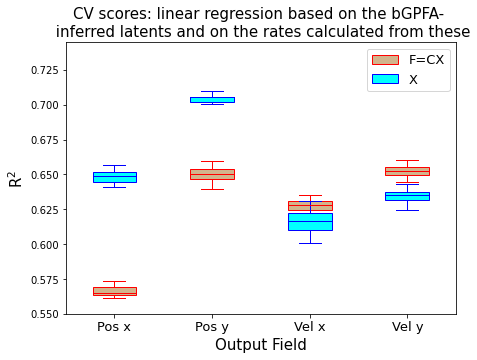

In [92]:
cv_rates_bGPFA_hist = [cv_scores_F_hist_posx,cv_scores_F_hist_posy, cv_scores_F_hist_velx, cv_scores_F_hist_vely ]
cv_latents_bGPFA_hist = [cv_scores_X_hist_posx,cv_scores_X_hist_posy, cv_scores_X_hist_velx, cv_scores_X_hist_vely ]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_rates_bGPFA_hist, 'red', 'tan')
bp2 = box_plot(cv_latents_bGPFA_hist, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['F=CX', 'X'], fontsize=13)
ax.set_ylim(0.55, 0.745)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: linear regression based on the bGPFA- \n inferred latents and on the rates calculated from these', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('APPENDIX_LR_scores_bGPFA_XvsF.jpeg')

In [76]:
with open("file.txt", 'w') as f:
    for s in cv_latents_bGPFA_hist:
        f.write(str(s) + '\n')

with open("file.txt", 'r') as f:
    cv_latents_bGPFA_hist = [line.rstrip('\n') for line in f]


print(cv_latents_bGPFA_hist)
#scores=[float(s) for s in cv_latents_bGPFA_hist]
#scores

['[0.65629053 0.64713005 0.65166572 0.64957239 0.63896023 0.64596978', ' 0.65910949 0.64648526 0.64324682 0.64627886]', '[0.70320747 0.69775654 0.70246906 0.70972826 0.70567342 0.70557794', ' 0.70261787 0.70660561 0.70291617 0.69704349]', '[0.619568   0.61179786 0.61741038 0.62084735 0.61195266 0.61820548', ' 0.61794666 0.61601891 0.61203508 0.61859402]', '[0.62978779 0.63969121 0.63110648 0.63838007 0.6428712  0.62290938', ' 0.6347137  0.63841247 0.63671569 0.63439683]']


In [77]:
with open("file1.txt", 'w') as f:
    for s in cv_scores_X_hist_posx:
        f.write(str(s) + '\n')
with open("file2.txt", 'w') as f:
    for s in cv_scores_X_hist_posy:
        f.write(str(s) + '\n')
with open("file3.txt", 'w') as f:
    for s in cv_scores_X_hist_velx:
        f.write(str(s) + '\n')
with open("file4.txt", 'w') as f:
    for s in cv_scores_X_hist_vely:
        f.write(str(s) + '\n')
